# Multi-Layer Perceptron

![multi-layer](assets/multi-perceptron.png)

## A simple Example of a non-linearly separable: XOR

In [1]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Global Settings

In [3]:
LABELS = [0,0,1,1]
MARKERS = ["o", "*"]
COLORS = ["black", "white"]
CENTERS = [(-3,-3),(3,3),(3,-3),(-3,3)]

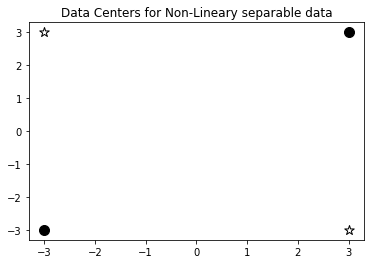

In [4]:
plt.title("Data Centers for Non-Lineary separable data")
for label_idx, center_ in enumerate(CENTERS):
    plt.scatter(center_[0], center_[1], marker=MARKERS[LABELS[label_idx]], 
                edgecolor="black", facecolor=COLORS[LABELS[label_idx]], s=100)
plt.show()

### Defining the Model

In [5]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_size=2, output_size=3,
                num_hidden_layers=1, hidden_activation=nn.Sigmoid):
        """Initialize weights
        
        Args:
            input_size (int): size of the input
            hidden_size (int): size of the hidden layers (depth)
            output_size (int): size of the output
            num_hidden_layers (int): number of hidden layers (large)
            hidde_activation (torch.nn.*):  the activation class
        """
        super(MultiLayerPerceptron, self).__init__()
        self.module_list = nn.ModuleList()
        
        interim_input_size = input_size
        interim_output_size = output_size
        
        for _ in range(num_hidden_layers):
            self.module_list.append(nn.Linear(interim_input_size, interim_output_size))
            self.module_list.append(hidden_activation())
            interim_input_size = interim_output_size
        
        self.fc_final = nn.Linear(interim_input_size, output_size)
        self.last_forward_cache = []
        
    def forward(self, x, apply_softmax=False):
        """The forward pass of the MLP
        Args:
            x (torch.Tensor): an input data tensor.
                        x.shape should be (batch, input_size)
            apply_softmax (bool): a flag for the softmax activation
                        should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_size)
        """
        self.last_forward_cache = []
        self.last_forward_cache.append(x.to('cpu').numpy())
        
        for module in self.module_list:
            x = module(x)
            self.last_forward_cache.append(x.to('cpu').data.numpy())
        
        output = self.fc_final(x)
        self.last_forward_cache.append(output.to('cpu').data.numpy())
        
        if apply_softmax:
            output = F.softmax(output, dim=1)
        
        return output

### Get Data Function

In [6]:
def get_toy_data(batch_size):
    assert len(CENTERS) == len(LABELS), 'centers should have equal number labels'
    
    x_data = []
    y_targets = np.zeros(batch_size)
    n_centers = len(CENTERS)
    
    for batch_i in range(batch_size):
        center_idx = np.random.randint(0, n_centers)
        x_data.append(np.random.normal(loc=CENTERS[center_idx]))
        y_targets[batch_i] = LABELS[center_idx]
    
    return torch.tensor(x_data, dtype=torch.float32), torch.tensor(y_targets, dtype=torch.int)

### Visualizing Results Function

In [7]:
from IPython import display
plt.ion() # Allow live updates of plots

def visualize_results(perceptron, x_data, y_truth, n_samples=1000, ax=None, 
                     epoch=None, title='', levels=[0.3, 0.4, 0.5],
                     linestyles=['--','-','--'], interactive=True):
    
    if interactive:
        ax.clear()# Live plots
    # Forward propagate throught the network and apply argmax
    _, y_pred = perceptron(x_data, apply_softmax=True).max(dim=1)
    y_pred = y_pred.data.numpy()
    
    x_data = x_data.data.numpy()
    y_truth = y_truth.data.numpy()
    
    n_classes = len(set(LABELS))
    
    all_x = [[] for _ in range(n_classes)]
    all_colors = [[] for _ in range(n_classes)]
    
    colors = ["black", "white"]
    markers = ["o", "*"]
    
    for x_i, y_pred_i, y_true_i in zip(x_data, y_pred, y_truth):
        all_x[y_true_i].append(x_i)
        if y_pred_i == y_true_i:
            all_colors[y_true_i].append("white")
        else:
            all_colors[y_true_i].append("black")
            
    all_x = [np.stack(x_list) for x_list in all_x]
    
    for x_list, color_list, marker in zip(all_x, all_colors, markers):
        ax.scatter(x_list[:,0], x_list[:,1], edgecolor="black",
                  marker=marker, facecolor=color_list, s=100)
    
    xlim = (min([x_list[:,0].min() for x_list in all_x]), 
            max([x_list[:,0].max() for x_list in all_x]))
            
    ylim = (min([x_list[:,1].min() for x_list in all_x]), 
            max([x_list[:,1].max() for x_list in all_x]))
    
    # HyperPlane
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
        
    for i in range(n_classes):
        Z = perceptron(torch.tensor(xy, dtype=torch.float32), 
                       apply_softmax=True)
        Z  = Z[:, i].data.numpy().reshape(XX.shape)
        ax.contour(XX, YY, Z, colors=colors[i], levels=levels, linestyles=linestyles)
    
    # plotting niceties
    if epoch is not None:
        plt.title("Epoch = {} ".format(str(epoch))+title)
    else:
        plt.title(title)
        
    if interactive:
        display.clear_output(wait=True)
        display.display(ax.figure)

### Initial Data Pot

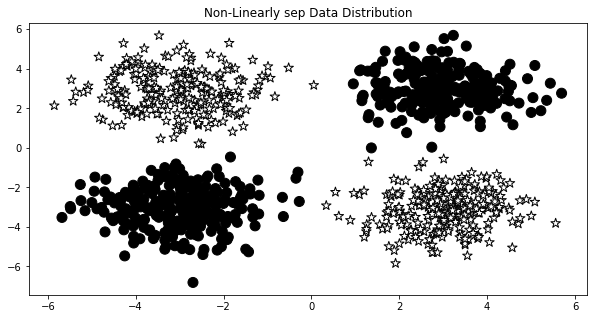

In [8]:
batch_size = 1000
x, y = get_toy_data(batch_size)

all_x = [[] for _ in range(len(set(LABELS)))]
all_colors = [[] for _ in range(len(set(LABELS)))]

plt.figure(figsize=(10, 5))
plt.title("Non-Linearly sep Data Distribution")

for x_i, y_true_i in zip(x, y):
    all_x[y_true_i].append(x_i)
    all_colors[y_true_i].append(COLORS[y_true_i])

all_x = [np.stack(x_list) for x_list in all_x]

for x_list, color_list, marker in zip(all_x, all_colors, MARKERS):
    plt.scatter(x_list[:,0], x_list[:, 1], edgecolors="black",
               marker=marker, facecolor=color_list, s=100)
plt.show()

### Training Perceptron

MultiLayerPerceptron(
  (module_list): ModuleList()
  (fc_final): Linear(in_features=2, out_features=2, bias=True)
)


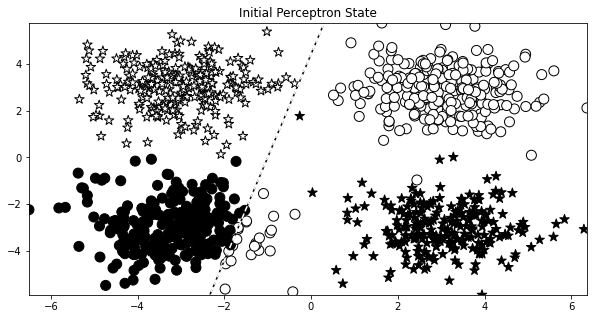

In [9]:
input_size = 2
output_size = len(set(LABELS))
num_hidden_layers = 0
hidden_size = 2 # isn't ever used but we still set it


seed = 24

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

mlp1 = MultiLayerPerceptron(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_hidden_layers=num_hidden_layers, 
                            output_size=output_size)
batch_size = 1000

x_data_static, y_truth_static = get_toy_data(batch_size)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
visualize_results(mlp1, x_data_static, y_truth_static, 
                  ax=ax, title='Initial Perceptron State', levels=[0.5], interactive=False)
print(mlp1)

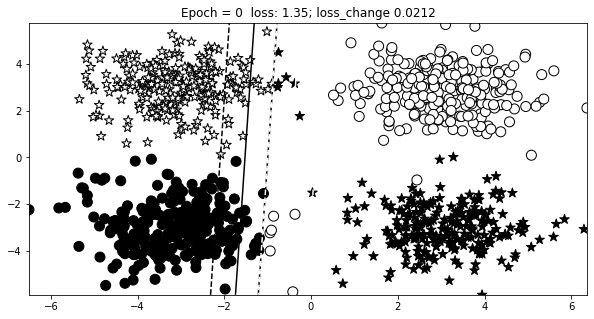

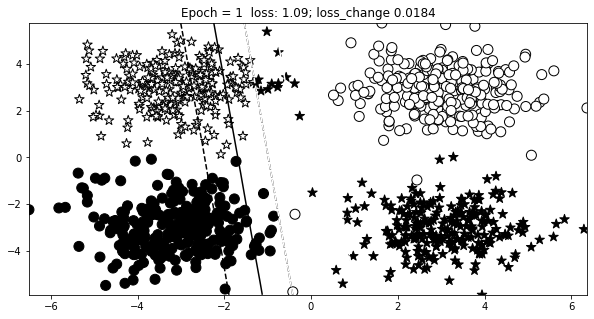

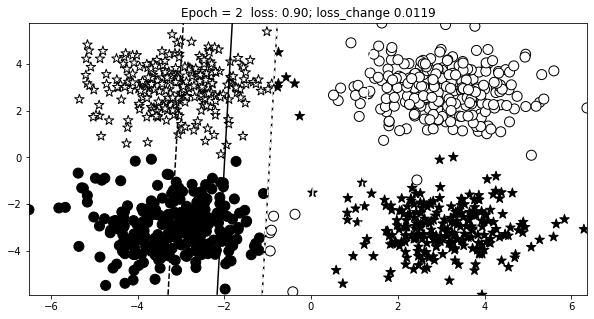

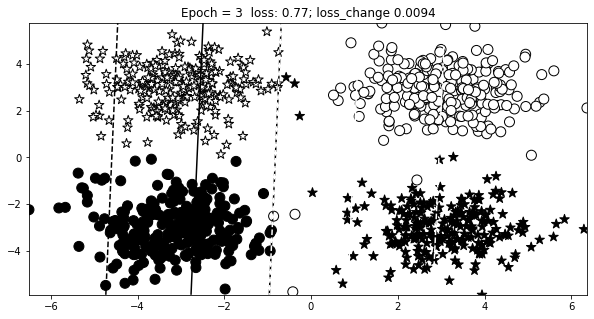

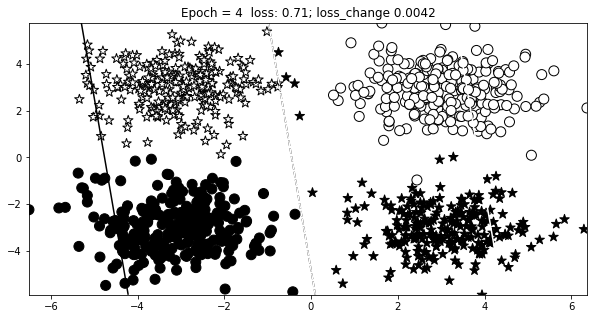

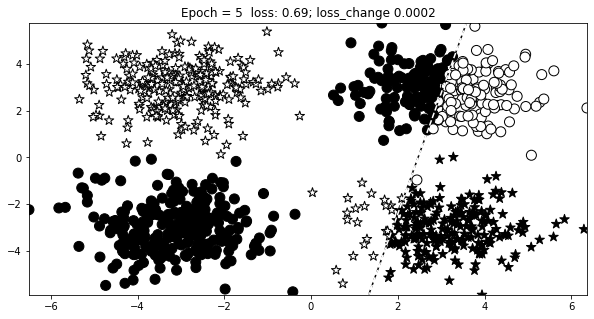

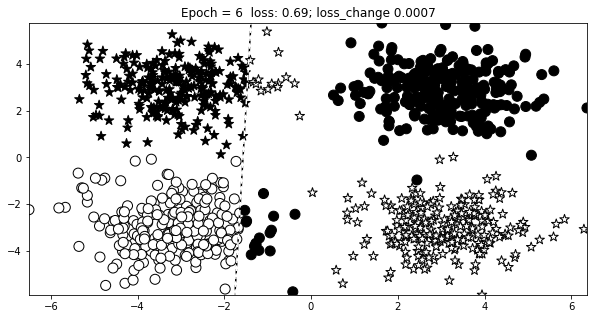

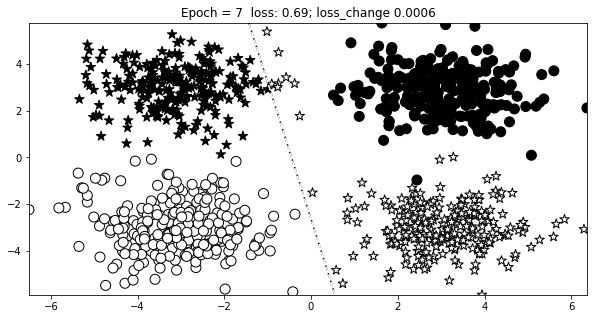

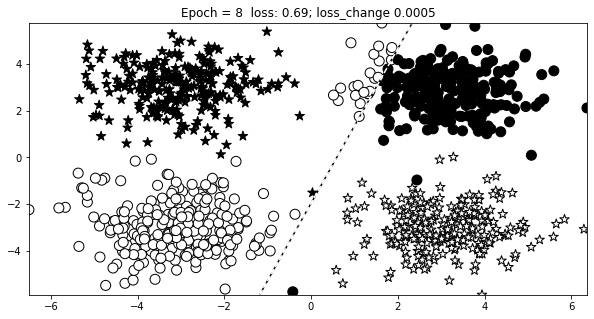

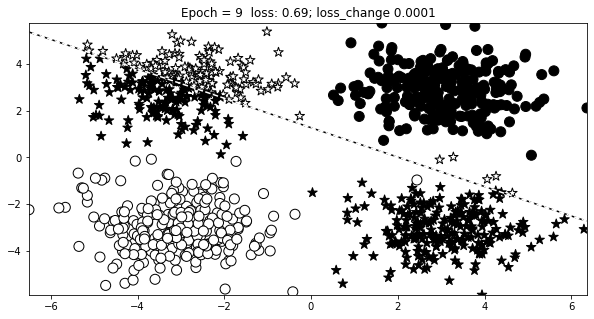

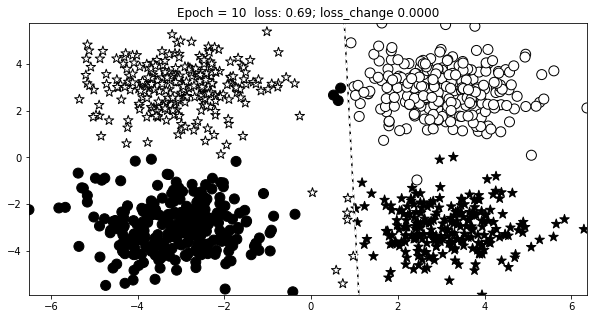

In [10]:
losses = []
batch_size = 10000
n_batches = 10
max_epochs = 10

loss_change = 1.0
last_loss = 10.0
change_threshold = 1e-3
epoch = 0

lr = 0.01
optimizer = optim.Adam(params=mlp1.parameters(), lr=lr)
cross_ent_loss = nn.CrossEntropyLoss()


def early_termination(loss_change, change_threshold, epoch, max_epochs):
    terminate_for_loss_change = loss_change < change_threshold
    terminate_for_epochs = epoch > max_epochs
    
    #return terminate_for_loss_change or 
    return terminate_for_epochs

while not early_termination(loss_change, change_threshold, epoch, max_epochs):
    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    
    for _ in range(n_batches):
        # step 0: fetch the data
        x_data, y_target = get_toy_data(batch_size)
 
        # step 1: zero the gradients
        mlp1.zero_grad()
        
        # step 2: run the forward pass
        y_pred = mlp1(x_data).squeeze()
        
        # step 3: compute the loss
        loss = cross_ent_loss(y_pred, y_target.long())

        # step 4: compute the backward pass
        loss.backward()
        
        # step 5: have the optimizer take an optimization step
        optimizer.step()
        
        # auxillary: bookkeeping
        loss_value = loss.item()
        losses.append(loss_value)
        loss_change = abs(last_loss - loss_value)
        last_loss = loss_value
                
    visualize_results(mlp1, x_data_static, y_truth_static, ax=ax, epoch=epoch, 
                      title=f" loss: {loss_value:0.2f}; loss_change {loss_change:0.4f}")
    epoch += 1
display.clear_output()

### Training a 2 layers perceptron

MultiLayerPerceptron(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Sigmoid()
  )
  (fc_final): Linear(in_features=2, out_features=2, bias=True)
)


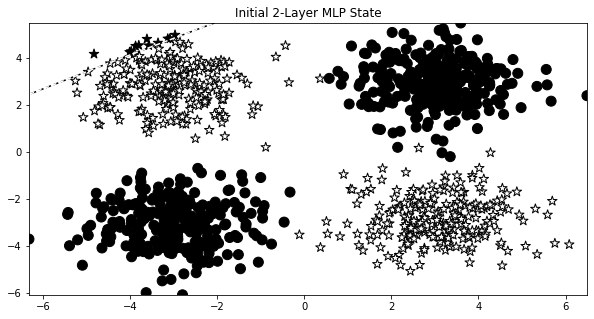

In [11]:
input_size = 2
output_size = len(set(LABELS))
num_hidden_layers = 1
hidden_size = 2

seed = 2

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

mlp2 = MultiLayerPerceptron(input_size=input_size, 
                           hidden_size=hidden_size, 
                           num_hidden_layers=num_hidden_layers, 
                           output_size=output_size)
batch_size = 1000

x_data_static, y_truth_static = get_toy_data(batch_size)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
visualize_results(mlp2, x_data_static, y_truth_static, 
                  ax=ax, title='Initial 2-Layer MLP State', levels=[0.5])
display.clear_output()
print(mlp2)

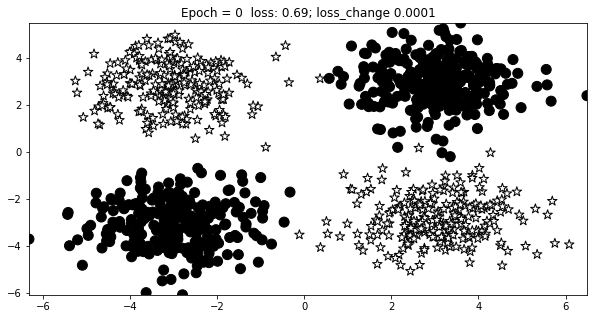

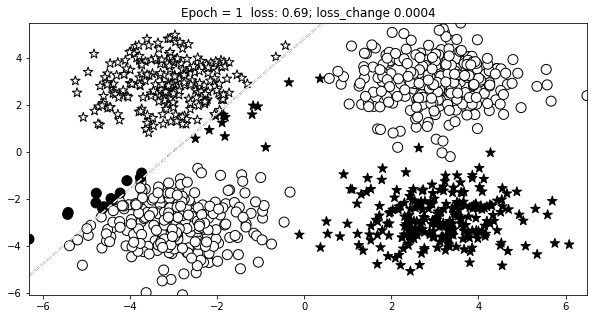

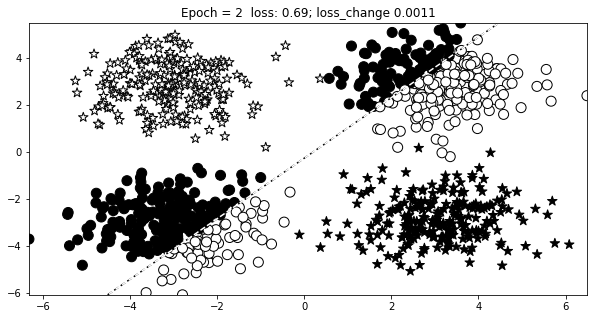

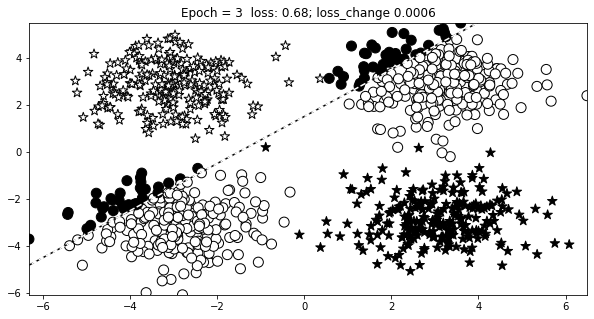

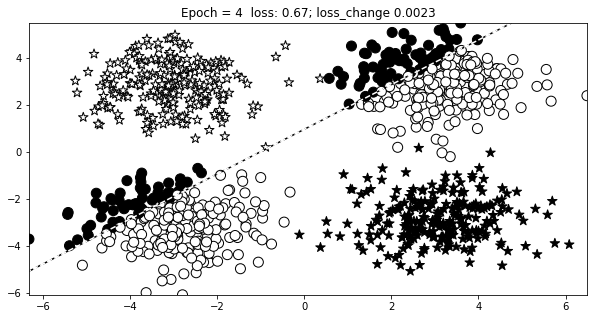

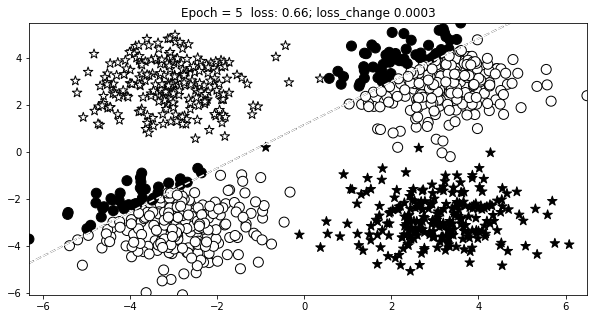

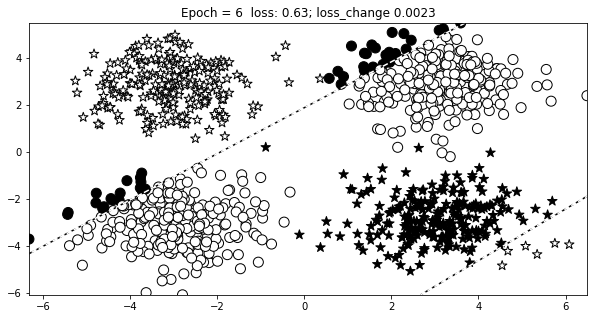

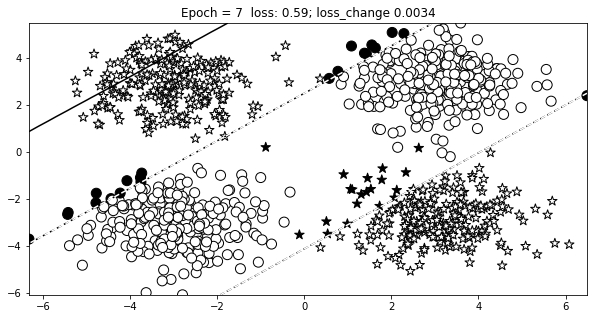

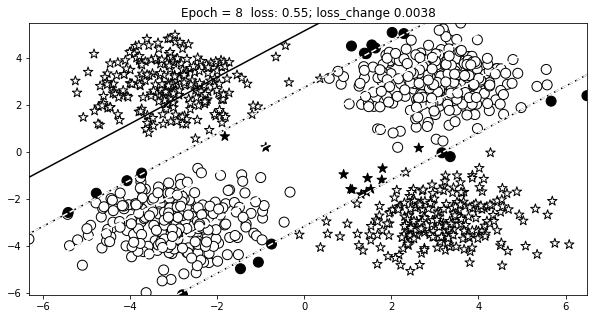

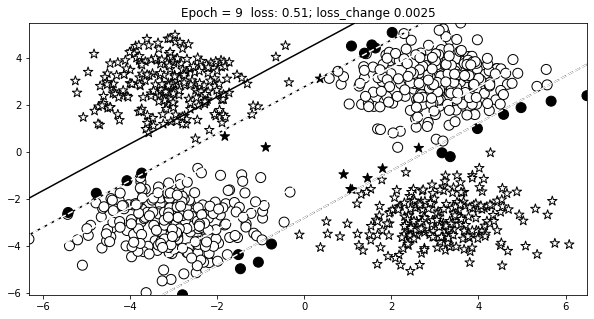

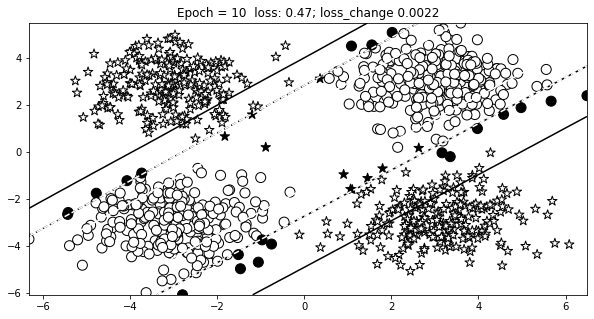

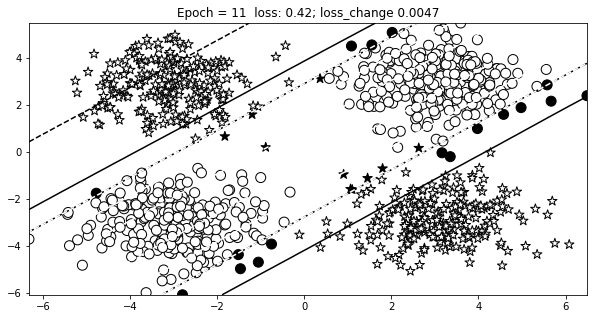

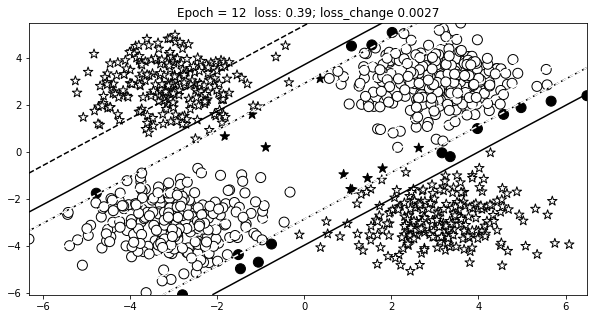

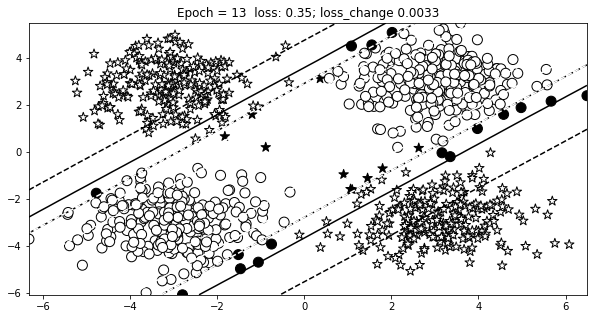

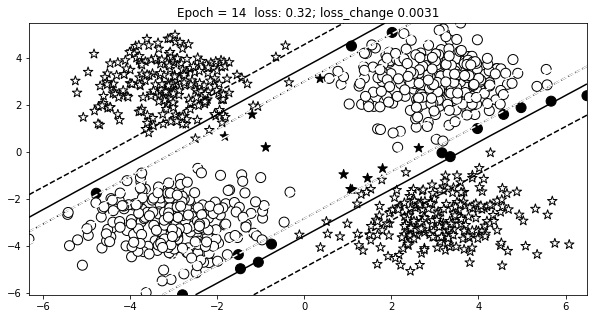

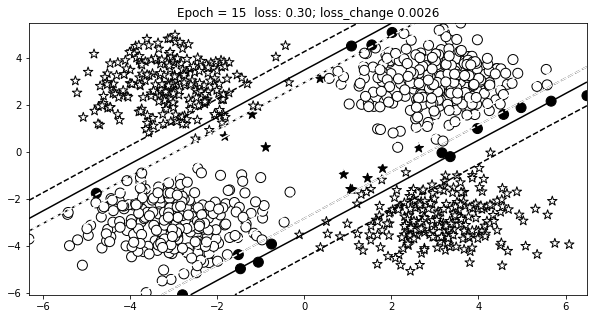

In [12]:
losses = []
batch_size = 10000
n_batches = 10
max_epochs = 15

loss_change = 1.0
last_loss = 10.0
change_threshold = 1e-5
epoch = 0

lr = 0.01
optimizer = optim.Adam(params=mlp2.parameters(), lr=lr)
cross_ent_loss = nn.CrossEntropyLoss()

def early_termination(loss_change, change_threshold, epoch, max_epochs):
    terminate_for_loss_change = loss_change < change_threshold    
    terminate_for_epochs = epoch > max_epochs
    
    #return terminate_for_loss_change or 
    return terminate_for_epochs

while not early_termination(loss_change, change_threshold, epoch, max_epochs):
    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    
    for _ in range(n_batches):
        # step 0: fetch the data
        x_data, y_target = get_toy_data(batch_size)
 
        # step 1: zero the gradients
        mlp2.zero_grad()
        
        # step 2: run the forward pass
        y_pred = mlp2(x_data).squeeze()
        
        # step 3: compute the loss
        loss = cross_ent_loss(y_pred, y_target.long())

        # step 4: compute the backward pass
        loss.backward()
        
        # step 5: have the optimizer take an optimization step
        optimizer.step()
        
        # auxillary: bookkeeping
        loss_value = loss.item()
        losses.append(loss_value)
        loss_change = abs(last_loss - loss_value)
        last_loss = loss_value
                
    visualize_results(mlp2, x_data_static, y_truth_static, ax=ax, epoch=epoch, 
                     title=f" loss: {loss_value:0.2f}; loss_change {loss_change:0.4f}")
    epoch += 1
    
display.clear_output()

### Training a 3 layers perceptron

MultiLayerPerceptron(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=2, out_features=2, bias=True)
    (3): Sigmoid()
  )
  (fc_final): Linear(in_features=2, out_features=2, bias=True)
)


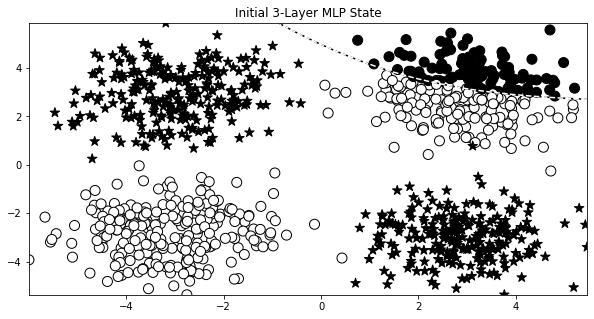

In [13]:
input_size = 2
output_size = len(set(LABELS))
num_hidden_layers = 2
hidden_size = 2

seed = 399

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

mlp3 = MultiLayerPerceptron(input_size=input_size, 
                           hidden_size=hidden_size, 
                           num_hidden_layers=num_hidden_layers, 
                           output_size=output_size)
batch_size = 1000

x_data_static, y_truth_static = get_toy_data(batch_size)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
visualize_results(mlp3, x_data_static, y_truth_static, 
                  ax=ax, title='Initial 3-Layer MLP State', levels=[0.5], interactive=False)
print(mlp3)

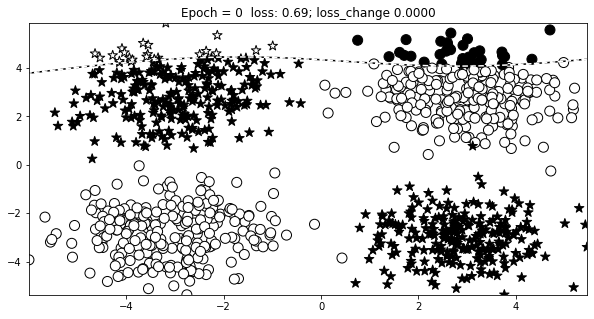

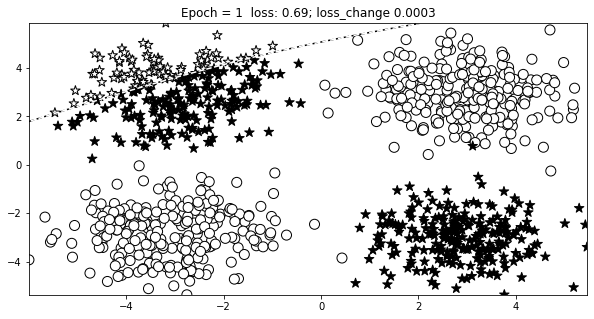

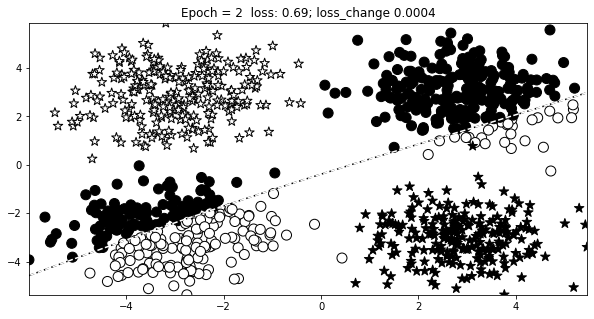

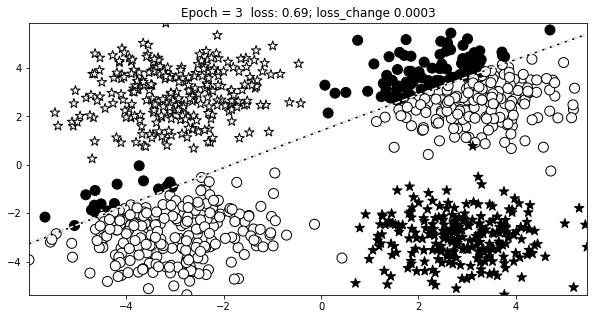

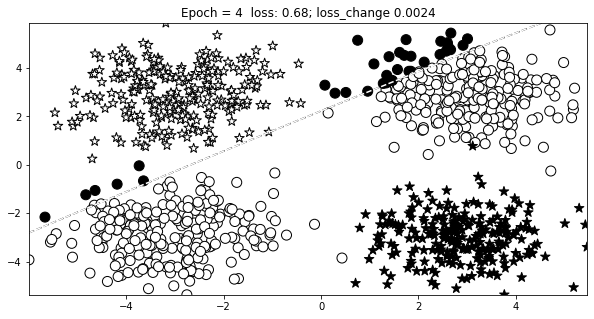

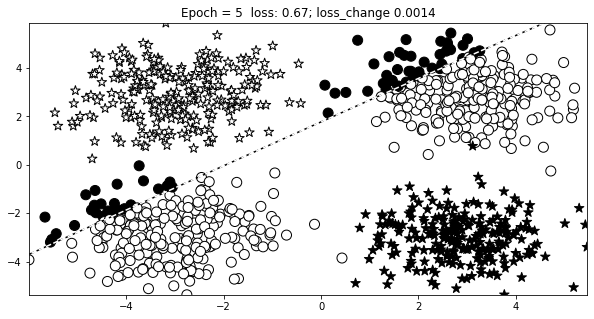

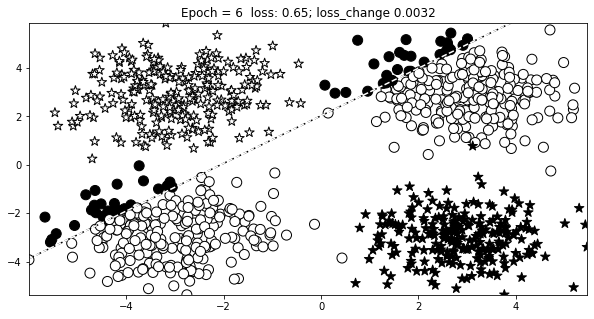

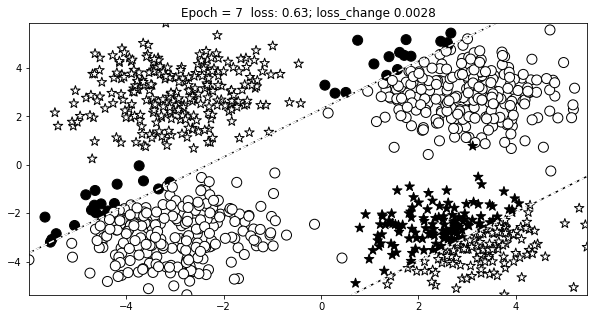

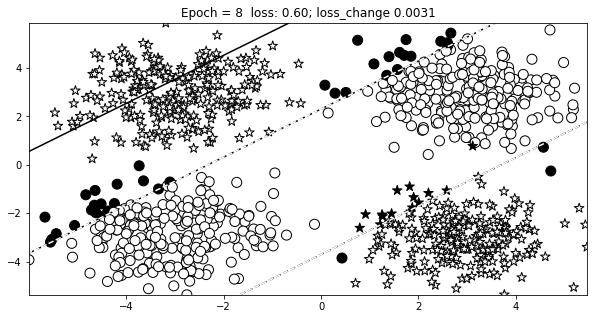

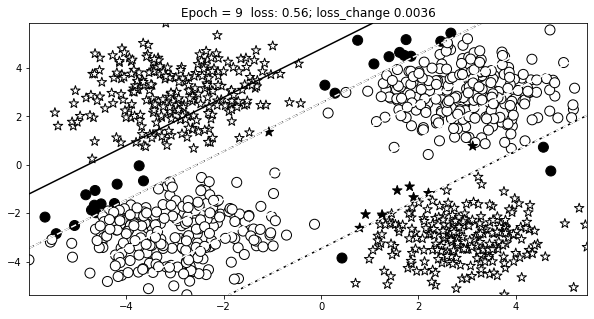

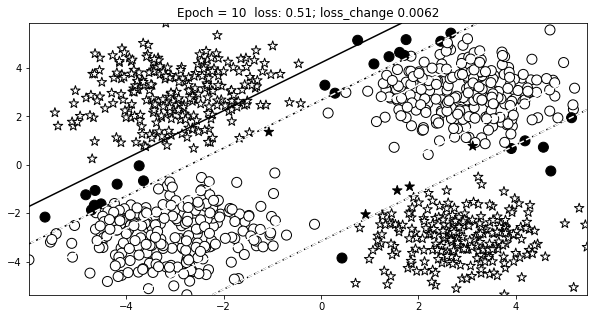

In [14]:
losses = []
batch_size = 10000
n_batches = 10
max_epochs = 10

loss_change = 1.0
last_loss = 10.0
change_threshold = 1e-5
epoch = 0

lr = 0.01
optimizer = optim.Adam(params=mlp3.parameters(), lr=lr)
cross_ent_loss = nn.CrossEntropyLoss()
    
def early_termination(loss_change, change_threshold, epoch, max_epochs):
    terminate_for_loss_change = loss_change < change_threshold    
    terminate_for_epochs = epoch > max_epochs
    
    #return terminate_for_loss_change or 
    return terminate_for_epochs

while not early_termination(loss_change, change_threshold, epoch, max_epochs):
    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    
    for _ in range(n_batches):
        # step 0: fetch the data
        x_data, y_target = get_toy_data(batch_size)
 
        # step 1: zero the gradients
        mlp3.zero_grad()
        
        # step 2: run the forward pass
        y_pred = mlp3(x_data).squeeze()
        
        # step 3: compute the loss
        loss = cross_ent_loss(y_pred, y_target.long())

        # step 4: compute the backward pass
        loss.backward()
        
        # step 5: have the optimizer take an optimization step
        optimizer.step()
        
        # auxillary: bookkeeping
        loss_value = loss.item()
        losses.append(loss_value)
        loss_change = abs(last_loss - loss_value)
        last_loss = loss_value
                
    visualize_results(mlp3, x_data_static, y_truth_static, ax=ax, epoch=epoch, 
                      title=f" loss: {loss_value:0.2f}; loss_change {loss_change:0.4f}")
    epoch += 1
    
display.clear_output()

### Compare Different results

In [15]:
plt.ioff()

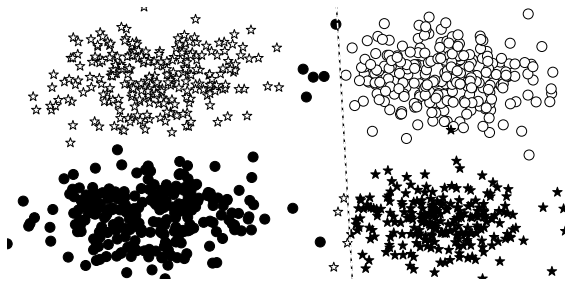

In [16]:
_, ax = plt.subplots(1,1,figsize=(10,5))
visualize_results(mlp1, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=ax, interactive=False)
plt.axis('off');

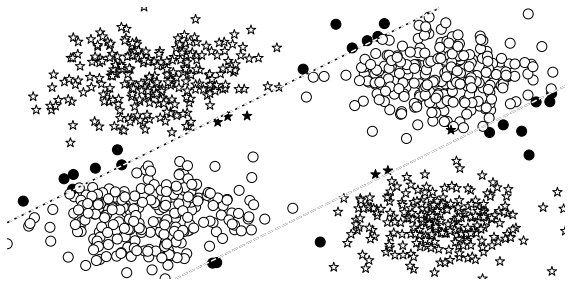

In [17]:
_, ax = plt.subplots(1,1,figsize=(10,5))
visualize_results(mlp2, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=ax, interactive=False)
plt.axis('off');

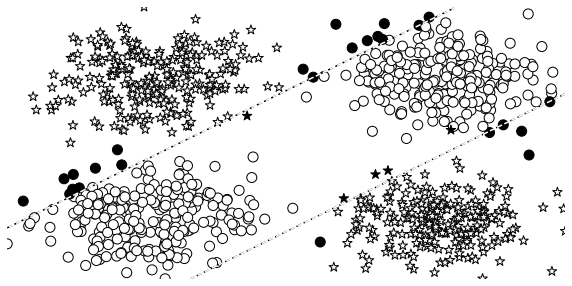

In [18]:
_, ax = plt.subplots(1,1,figsize=(10,5))
visualize_results(mlp3, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=ax, interactive=False)
plt.axis('off');

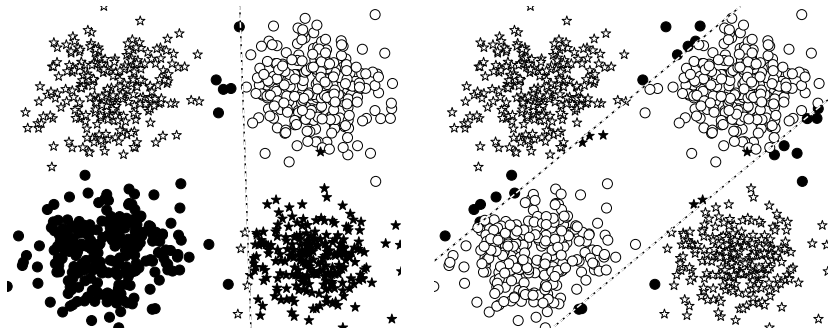

In [19]:
plt.ioff()
_, axes = plt.subplots(1,2,figsize=(12,5))
visualize_results(mlp1, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=axes[0], interactive=False)
visualize_results(mlp2, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=axes[1], interactive=False)
plt.tight_layout()
axes[0].axis('off');
axes[1].axis('off');

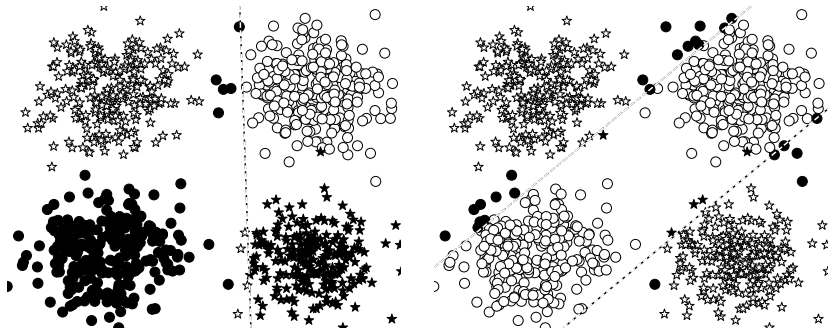

In [20]:
_, axes = plt.subplots(1,2, figsize=(12,5))
visualize_results(mlp1, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=axes[0], interactive=False)
visualize_results(mlp3, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=axes[1], interactive=False)
plt.tight_layout()
axes[0].axis('off');
axes[1].axis('off');

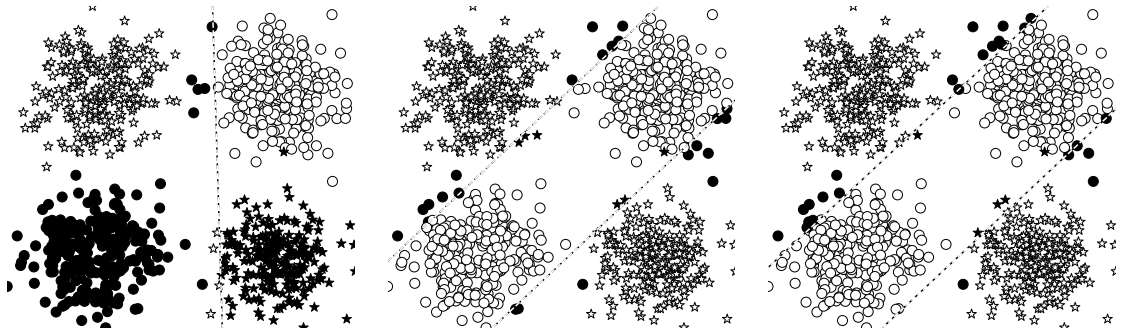

In [21]:
_, axes = plt.subplots(1,3,figsize=(16,5))
visualize_results(mlp1, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=axes[0], interactive=False)
visualize_results(mlp2, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=axes[1], interactive=False)
visualize_results(mlp3, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=axes[2], interactive=False)
plt.tight_layout()
axes[0].axis('off');
axes[1].axis('off');
axes[2].axis('off');

### Inspecting the representations

As you knwo neural networks learn representation throught each layer.

In [22]:
batch_size = 100

In [52]:
def plot_intermediate_representations(mlp_model, plot_title, figsize=(10,2)):
    mlp_model.eval()
    x_data, y_target = get_toy_data(batch_size)
    y_pred = mlp_model(x_data, True).detach().numpy()
    
    x_data = x_data.numpy()
    y_target = y_target.numpy()
    
    colors = ["black", "white"]
    markers = ["o", "*"]
    
    plot_markers = []
    class_zero_indices = (y_target - 1).nonzero()[0]
    class_one_indices = (y_target).nonzero()[0]
    
    fig, axes = plt.subplots(1, len(mlp_model.last_forward_cache), figsize=figsize)
    
    for class_index, data_indices in enumerate([class_zero_indices, class_one_indices]):
        for i, activations in enumerate(mlp_model.last_forward_cache):
            axes[i].scatter(activations[data_indices, 0], activations[data_indices, 1], edgecolor="black",
                       facecolor="white", marker=markers[class_index], s=[200,400][class_index])
            axes[i].axis('off')
    plt.tight_layout()
    
    plt.suptitle(plot_title, size=15)
    plt.subplots_adjust(top=0.75)

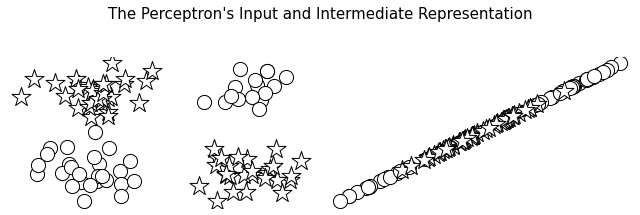

In [53]:
plot_intermediate_representations(mlp1, 
                                  "The Perceptron's Input and Intermediate Representation",
                                  figsize=(9, 3))

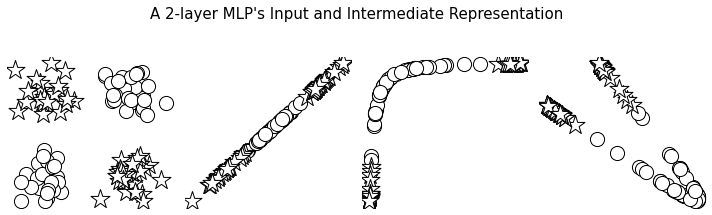

In [55]:
plot_intermediate_representations(mlp2,
                                  "A 2-layer MLP's Input and Intermediate Representation",
                                  figsize=(10, 3))

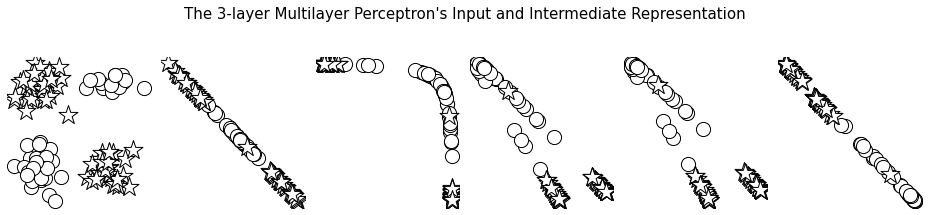

In [54]:
plot_intermediate_representations(mlp3, 
                                  "The 3-layer Multilayer Perceptron's Input and Intermediate Representation",
                                  figsize=(13, 3))